In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from particletracking import dataframes
from tqdm import tqdm

In [10]:
%matplotlib inline

### Load the datasets

In [11]:
data_flat = dataframes.DataStore("/media/data/Data/FirstOrder/Susceptibility/Flat2/17500093.hdf5")
flat_points = data_flat.df.loc[0].copy()

data_dimpled = dataframes.DataStore("/media/data/Data/FirstOrder/Susceptibility/Dimpled2/17480099.hdf5") 
dimpled_points = data_dimpled.df.loc[0].copy()

### Get all the vectors between the points

In [12]:
def get_delaunay_vectors(points):
    tri = spatial.Delaunay(points[['x', 'y']])
    triangles = tri.points[tri.simplices]
    vecs = np.array([t - t[[2, 0, 1], :] for t in triangles])
    vecs = vecs.reshape((-1, 2))
    return vecs

In [13]:
flat_vecs = get_delaunay_vectors(flat_points)
dimpled_vecs = get_delaunay_vectors(dimpled_points)

### Get all the angles of the vectors

In [14]:
def get_delaunay_angles(vecs):
    return np.arctan(vecs[:, 1]/vecs[:, 0])

In [15]:
flat_angles = get_delaunay_angles(flat_vecs)
dimpled_angles = get_delaunay_angles(dimpled_vecs)

/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


### Calculate the correct angle

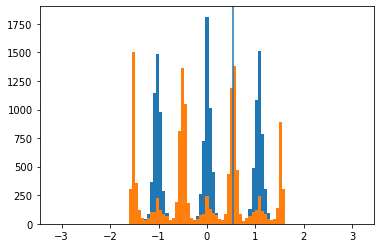

In [16]:
_, _, _ = plt.hist(flat_angles, bins=np.linspace(-np.pi, np.pi, 100))
_, _, _ = plt.hist(dimpled_angles, bins=np.linspace(-np.pi, np.pi, 100))
plt.axvline(np.median(dimpled_angles[(dimpled_angles>0)&(dimpled_angles<np.pi/3)]))

In [17]:
def get_delaunay_angle(angles, flat=False):
    if flat:
        angles = angles[[(angles>-np.pi/4)&(angles<np.pi/4)]]
    else:
        angles = angles[[(angles>0)&(angles<np.pi/3)]]
    return np.median(angles)*180 / np.pi

In [18]:
flat_angle = get_delaunay_angle(flat_angles, True)
dimpled_angle = get_delaunay_angle(dimpled_angles, False)
flat_angle, dimpled_angle

/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


(1.2453642667683473, 30.96375653207352)

### Calculate the correct length

In [19]:
def get_delaunay_lengths(vecs):
    lengths = np.linalg.norm(vecs, axis=1)
    return lengths

In [20]:
flat_lengths = get_delaunay_lengths(flat_vecs)
dimpled_lengths = get_delaunay_lengths(dimpled_vecs)

In [21]:
def get_delaunay_length(lengths):
    return np.median(lengths)

In [22]:
flat_length = get_delaunay_length(flat_lengths)
dimpled_length = get_delaunay_length(dimpled_lengths)

### Calculate G

In [23]:
def get_G(length, angle):
    """Get G from the lengthscale of the lattice and the angle in degrees"""
    a = (angle+90) * np.pi/180 
    cosa = np.cos(a)
    sina = np.sin(a)
    l = 4*np.pi / (length * np.sqrt(3))
    return np.array((cosa, sina))*l

In [24]:
flat_G = get_G(flat_length, flat_angle)
dimpled_G = get_G(dimpled_length, dimpled_angle)

### Calculate translational order

In [25]:
def add_torder(data, G):
    data['torder'] = np.exp(1j* data[['x', 'y']].values@G)
    return data

In [133]:
flat_points = add_torder(flat_points, flat_G)

In [134]:
dimpled_points = add_torder(dimpled_points, dimpled_G)

### Plot translational order

In [28]:
def quiver_torder(data):
    torder = data.torder.values
    plt.quiver(data.x, data.y, torder.real, torder.imag, np.angle(torder), pivot='mid', cmap='hsv')
    plt.clim([-np.pi, np.pi])
    plt.colorbar()

In [132]:
quiver_torder(flat_points)

In [130]:
%matplotlib auto
quiver_torder(dimpled_points)

Using matplotlib backend: Qt5Agg


### Calculate for all frames

In [31]:
data_dimpled.df = add_torder(data_dimpled.df, dimpled_G)

In [32]:
data_flat.df = add_torder(data_flat.df, flat_G)

### Calculate the susceptibility

In [33]:
def mean_frame_values(points, param, dist=None):
    if dist is not None:
        points = points.loc[points.edge_distance > dist]
    vals = points[param].values
    return np.mean(vals)

In [34]:
def sus_of_dataframe(data, param, dist=None):
    means = data.df.groupby('frame').apply(mean_frame_values, param, dist)
    sus = np.mean(means * np.conj(means)) - np.mean(means)*np.conj(np.mean(means))
    return sus.real
    

In [35]:
sus = sus_of_dataframe(data_dimpled, 'torder', dist=3*data_dimpled.df.r.mean())

### Calculate the susceptibility for all dataframes to plot the graph

In [36]:
def duty(data):
    return int(data.df.Duty.mean())

In [37]:
import filehandling

In [38]:
flat_files = filehandling.get_directory_filenames("/media/data/Data/FirstOrder/Susceptibility/Flat2/*.hdf5")

In [39]:
dimpled_files = filehandling.get_directory_filenames("/media/data/Data/FirstOrder/Susceptibility/Dimpled2/*.hdf5")

In [ ]:
def process_file(file, G):
    data = dataframes.DataStore(file)
    data.df = add_torder(data.df, G)
    d = duty(data)
    sus = sus_of_dataframe(data, 'torder', dist=3*data.df.r.mean())
    return d, sus

In [ ]:
flat_duties = []
flat_sus = []
for file in tqdm(flat_files):
    d, sus = process_file(file, flat_G)
    flat_duties.append(d)
    flat_sus.append(sus)

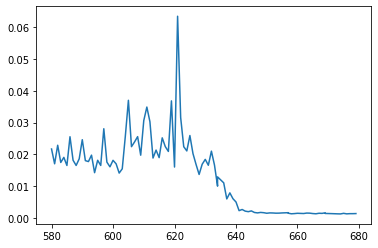

In [44]:
plt.plot(flat_duties, flat_sus)

In [ ]:
dimpled_duties = []
dimpled_sus = []
for file in tqdm(dimpled_files):
    d, sus = process_file(file, dimpled_G)
    dimpled_duties.append(d)
    dimpled_sus.append(sus)

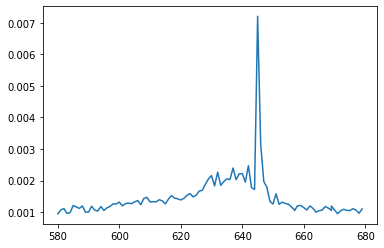

In [46]:
plt.plot(dimpled_duties, dimpled_sus)

### Repeat susceptibility for the hexatic order parameter

In [49]:
def process_file_horder(file):
    data = dataframes.DataStore(file)
    data.df['order_complex_long'] = data.df.order_r_long + 1j*data.df.order_i_long
    d = duty(data)
    sus = sus_of_dataframe(data, 'order_complex_long', dist=3*data.df.r.mean())
    return d, sus

In [ ]:
flat_duties_horder = []
flat_sus_horder = []
for file in tqdm(flat_files):
    d, sus = process_file_horder(file)
    flat_duties_horder.append(d)
    flat_sus_horder.append(sus)

In [ ]:
dimpled_duties_horder = []
dimpled_sus_horder = []
for file in tqdm(dimpled_files):
    d, sus = process_file_horder(file)
    dimpled_duties_horder.append(d)
    dimpled_sus_horder.append(sus)

### Plot both order sus

In [111]:
plt.rcParams.update({
    'font.size': 14,
    'lines.linewidth': 3,
    'figure.dpi': 100,
    'figure.figsize': (6.4, 4.8)
})

In [143]:
def apply_plot_style(fig, ax1, ax2):
    ax1.set_xlabel('Duty Cycle')
    ax1.set_ylabel('$\chi_T$', c='g')
    ax1.tick_params(axis='y', colors='g')
    ax2.set_ylabel('$\chi_6$', c='m')
    ax2.tick_params(axis='y', colors='m')

In [157]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [158]:
%matplotlib auto
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(flat_duties, flat_sus, 'g-')
ax1.set_title('Flat Data')
ax2.plot(flat_duties_horder, flat_sus_horder, 'm-')
apply_plot_style(fig, ax1, ax2)

Using matplotlib backend: Qt5Agg


In [159]:
fig, ax1 = plt.subplots()
ax1.set_title('Dimpled Data')
ax2 = ax1.twinx()

ax1.plot(dimpled_duties, dimpled_sus, 'g-')
ax2.plot(dimpled_duties_horder, dimpled_sus_horder, 'm-')
apply_plot_style(fig, ax1, ax2)

### What do histograms of translational order look like

In [124]:
def hist_data(file):
    data = dataframes.DataStore(file)
    data.df = add_torder(data.df, flat_G)
    freq, bins = np.histogram(np.angle(data.df.torder.values), bins=np.linspace(-np.pi, np.pi, 360))
    return bins, freq

In [125]:
flat_histogram_data = {
    d: hist_data(f) for d, f in tqdm(zip(flat_duties, flat_files))
}





0it [00:00, ?it/s]



1it [00:00,  1.39it/s]



2it [00:02,  1.07s/it]



3it [00:04,  1.35s/it]



4it [00:06,  1.52s/it]



5it [00:08,  1.63s/it]



6it [00:10,  1.69s/it]



7it [00:11,  1.46s/it]



8it [00:13,  1.59s/it]



9it [00:14,  1.68s/it]



10it [00:16,  1.75s/it]



11it [00:18,  1.79s/it]



12it [00:19,  1.59s/it]



13it [00:20,  1.32s/it]



14it [00:21,  1.14s/it]



15it [00:21,  1.01s/it]



16it [00:22,  1.09it/s]



17it [00:23,  1.18it/s]



18it [00:24,  1.25it/s]



19it [00:24,  1.31it/s]



20it [00:25,  1.34it/s]



21it [00:26,  1.37it/s]



22it [00:26,  1.39it/s]



23it [00:27,  1.40it/s]



24it [00:28,  1.41it/s]



25it [00:28,  1.43it/s]



26it [00:29,  1.42it/s]



27it [00:30,  1.43it/s]



28it [00:31,  1.43it/s]



29it [00:31,  1.43it/s]



30it [00:32,  1.43it/s]



31it [00:33,  1.42it/s]



32it [00:33,  1.41it/s]



33it [00:34,  1.41it/s]



34it [00:35,  1.20it/s]



35it [00:37,  1.17s/it]



36it [00:39,  1.42s/it]



37it [00:41

In [126]:
flat_histogram_data

{679: (array([-3.14159265, -3.12409074, -3.10658884, -3.08908693, -3.07158502,
         -3.05408311, -3.0365812 , -3.01907929, -3.00157738, -2.98407547,
         -2.96657356, -2.94907166, -2.93156975, -2.91406784, -2.89656593,
         -2.87906402, -2.86156211, -2.8440602 , -2.82655829, -2.80905638,
         -2.79155447, -2.77405257, -2.75655066, -2.73904875, -2.72154684,
         -2.70404493, -2.68654302, -2.66904111, -2.6515392 , -2.63403729,
         -2.61653539, -2.59903348, -2.58153157, -2.56402966, -2.54652775,
         -2.52902584, -2.51152393, -2.49402202, -2.47652011, -2.45901821,
         -2.4415163 , -2.42401439, -2.40651248, -2.38901057, -2.37150866,
         -2.35400675, -2.33650484, -2.31900293, -2.30150102, -2.28399912,
         -2.26649721, -2.2489953 , -2.23149339, -2.21399148, -2.19648957,
         -2.17898766, -2.16148575, -2.14398384, -2.12648194, -2.10898003,
         -2.09147812, -2.07397621, -2.0564743 , -2.03897239, -2.02147048,
         -2.00396857, -1.98646666

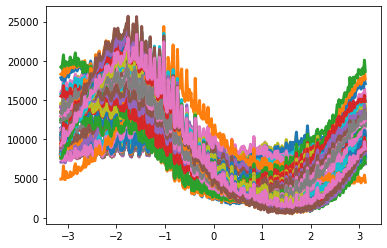

In [127]:
plt.figure()
for d, (b, f) in flat_histogram_data.items():
    plt.plot(b[:-1], f, label=d)